# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import ks_2samp
import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.metrics import roc_curve

%matplotlib inline

In [3]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [8]:
print(df.info())
print('Qtd linhas duplicadas:', df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB
None
Qtd linhas duplicadas: 0


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [24]:
def bivariada_qualitativa(dataframe: pd.DataFrame, x: str, y: str) -> pd.DataFrame:
    tabela_cruzada = pd.crosstab(index=dataframe[x], 
                                 columns=dataframe[y], 
                                 margins=True, 
                                 margins_name='total')
    
    tabela_cruzada['prob'] = tabela_cruzada[1] / tabela_cruzada['total']
    tabela_cruzada['odds'] = tabela_cruzada[1] / tabela_cruzada[0]
    tabela_cruzada['odds_ratio'] = tabela_cruzada['odds'] / tabela_cruzada.loc['total', 'odds']
    tabela_cruzada['logito'] = np.log(tabela_cruzada['odds'])
    tabela_cruzada['WOE'] = np.log(tabela_cruzada['odds'] / tabela_cruzada.loc['total', 'odds'])
    
    return tabela_cruzada

sex: sexo (1 = masculino; 0 = feminino)

In [25]:
bivariada_qualitativa(dataframe=df, x='sex', y='flag_doente')

flag_doente,0,1,total,prob,odds,odds_ratio,logito,WOE
sex,,,,,,,,
0.0,72,25,97,0.257732,0.347222,0.409672,-1.057790,-0.892398
1.0,92,114,206,0.553398,1.239130,1.461996,0.214410,0.379802
total,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


cp: tipo de dor no peito

In [26]:
bivariada_qualitativa(dataframe=df, x='cp', y='flag_doente')

flag_doente,0,1,total,prob,odds,odds_ratio,logito,WOE
cp,,,,,,,,
1.0,16,7,23,0.304348,0.437500,0.516187,-0.826679,-0.661286
2.0,41,9,50,0.180000,0.219512,0.258993,-1.516347,-1.350955
3.0,68,18,86,0.209302,0.264706,0.312315,-1.329136,-1.163743
4.0,39,105,144,0.729167,2.692308,3.176536,0.990399,1.155791
total,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


exang: angina induzida por exercício(1 = sim; 0 = não)

In [28]:
bivariada_qualitativa(dataframe=df, x='exang', y='flag_doente')

flag_doente,0,1,total,prob,odds,odds_ratio,logito,WOE
exang,,,,,,,,
0.0,141,63,204,0.308824,0.446809,0.527170,-0.805625,-0.640233
1.0,23,76,99,0.767677,3.304348,3.898655,1.195239,1.360632
total,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [35]:
def bivariada_quantitativa(dataframe: pd.DataFrame, 
                           x: str, 
                           y: str, 
                           q: int = 5) -> pd.DataFrame:
    # Criando os intervalos com qcut
    dataframe['bin'] = pd.qcut(dataframe[x], q=q, duplicates='drop')
    
    # Calculando a tabela cruzada
    tabela_cruzada = pd.crosstab(index=dataframe['bin'], 
                                 columns=dataframe[y], 
                                 margins=True, 
                                 margins_name='total')
    
    # Adicionando colunas de métricas
    tabela_cruzada['prob'] = tabela_cruzada[1] / tabela_cruzada['total']
    tabela_cruzada['odds'] = tabela_cruzada[1] / tabela_cruzada[0]
    tabela_cruzada['odds_ratio'] = tabela_cruzada['odds'] / tabela_cruzada.loc['total', 'odds']
    tabela_cruzada['logito'] = np.log(tabela_cruzada['odds'])
    tabela_cruzada['WOE'] = np.log(tabela_cruzada['odds'] / tabela_cruzada.loc['total', 'odds'])
    
    # Calculando a média quantitativa com observed=True no groupby
    media_quantitativa = dataframe.groupby('bin', observed=True)[x].mean()
    tabela_cruzada['media_quantitativa'] = media_quantitativa
    tabela_cruzada.loc['total', 'media_quantitativa'] = dataframe[x].mean()
    
    # Arredondando as médias
    tabela_cruzada['media_quantitativa'] = tabela_cruzada['media_quantitativa'].round()
    
    return tabela_cruzada

In [36]:
bivariada_quantitativa(dataframe=df, x='age', y='flag_doente')

flag_doente,0,1,total,prob,odds,odds_ratio,logito,WOE,media_quantitativa
bin,,,,,,,,,
"(28.999, 45.0]",47,16,63,0.253968,0.340426,0.401653,-1.077559,-0.912166,41.0
"(45.0, 53.0]",42,22,64,0.343750,0.523810,0.618020,-0.646627,-0.481235,50.0
"(53.0, 58.0]",32,39,71,0.549296,1.218750,1.437950,0.197826,0.363218,56.0
"(58.0, 62.0]",13,32,45,0.711111,2.461538,2.904261,0.900787,1.066179,60.0
"(62.0, 77.0]",30,30,60,0.500000,1.000000,1.179856,0.000000,0.165392,67.0
total,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000,54.0


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [37]:
reglog = smf.logit(formula='''flag_doente ~ 
                              sex 
                              + C(cp, Treatment(reference=4))
                              + trestbps 
                              + age
                              ''', data=df).fit()
reglog.summary()

Optimization terminated successfully.
         Current function value: 0.476154
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                            6
Date:                Wed, 22 Jan 2025   Pseudo R-squ.:                  0.3097
Time:                        11:14:51   Log-Likelihood:                -144.27
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.692e-25
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -5.8619      1.413     -4.147      0.000      -8.632      -3.092
C(cp, Treatment(reference=4))[T.1.0]    -2.4789      0.553     -4.485      0.000      -3.562      -1.396
C(cp, Treatment(reference=4))[T.2.0]    -2.5406      0.452     -5.622      0.000      -3.426      -1.655
C(cp, Treatment(reference=4))[T.3.0]    -2.4074      0.360     -6.690      0.000      -3.113      -1.702
sex                                      1.8094      0.353      5.130      0.000       1.118       2.501
trestbps                                 0.0193      0.009      2.261      0.024       0.003       0.036
age                                      0.0567      0.018      3.120      0.002       0.021       0.092
========================================================================================================
"""

In [39]:
print(f'A chance do perfil masculino para doença cardíaca é de {round(np.exp(1.8094), 2)} vezes com relação ao perfil feminino.\n')

print(f'A chance do perfil com angina típica (valor 1) é de {round(np.exp(-2.4789), 4)} vezes com relação ao perfil com tipo de dor no peito assintomático (valor 4).\n')
print(f'A chance do perfil com angina atípica (valor 2) é de {round(np.exp(-2.5406), 4)} vezes com relação ao perfil com tipo de dor no peito assintomático (valor 4).\n')
print(f'A chance do perfil com dor não-angina (valor 3) é de {round(np.exp(-2.4074), 4)} vezes com relação ao perfil com tipo de dor no peito assintomático (valor 4).\n')

print(f'A chance aumenta {round(np.exp(0.0193), 2)} para cada milímetro de mercúrio (mmHg) da pressão sanguínea na admissão ao hospital.\n')

print(f'A chance aumenta {round(np.exp(0.0567), 2)} para cada ano da idade.\n')

A chance do perfil masculino para doença cardíaca é de 6.11 vezes com relação ao perfil feminino.

A chance do perfil com angina típica (valor 1) é de 0.0838 vezes com relação ao perfil com tipo de dor no peito assintomático (valor 4).

A chance do perfil com angina atípica (valor 2) é de 0.0788 vezes com relação ao perfil com tipo de dor no peito assintomático (valor 4).

A chance do perfil com dor não-angina (valor 3) é de 0.09 vezes com relação ao perfil com tipo de dor no peito assintomático (valor 4).

A chance aumenta 1.02 para cada milímetro de mercúrio (mmHg) da pressão sanguínea na admissão ao hospital.

A chance aumenta 1.06 para cada ano da idade.



4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

In [42]:
df['predito'] = reglog.predict(exog=df)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente,bin,predito
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0,"(62.0, 77.0]",0.458229
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1,"(62.0, 77.0]",0.944123
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1,"(62.0, 77.0]",0.886566
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,"(28.999, 45.0]",0.134929
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0,"(28.999, 45.0]",0.027278


In [44]:
# Categorizando a probabilidade em 5 grupos
pred_cat = pd.qcut(x=df['predito'], q=5, duplicates='drop')

# Criando o agrupamento com observed=True para evitar o aviso
group_reg = df.groupby(by=pred_cat, observed=True)

# Calculando as métricas
qualid = (group_reg[['flag_doente']]
          .count()
          .rename(columns={'flag_doente': 'contagem'}))

qualid

,contagem
predito,
"(0.0131, 0.143]",62
"(0.143, 0.287]",59
"(0.287, 0.586]",62
"(0.586, 0.822]",59
"(0.822, 0.944]",61


In [45]:
# Calculando a probabilidade de evento predita média por grupo:

qualid['predito'] = group_reg['predito'].mean()
qualid

,contagem,predito
predito,,
"(0.0131, 0.143]",62,0.072008
"(0.143, 0.287]",59,0.209626
"(0.287, 0.586]",62,0.435175
"(0.586, 0.822]",59,0.708861
"(0.822, 0.944]",61,0.874819


In [46]:
# Calculando a taxa de eventos (média da variável indicadora de eventos) por grupo:

qualid['pct_doente'] = group_reg['flag_doente'].mean()
qualid

,contagem,predito,pct_doente
predito,,,
"(0.0131, 0.143]",62,0.072008,0.080645
"(0.143, 0.287]",59,0.209626,0.152542
"(0.287, 0.586]",62,0.435175,0.483871
"(0.586, 0.822]",59,0.708861,0.762712
"(0.822, 0.944]",61,0.874819,0.819672


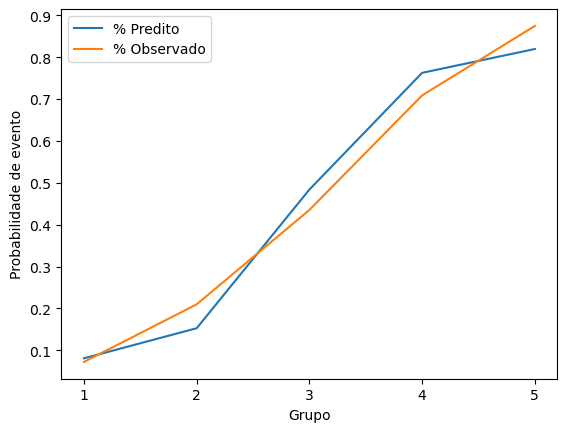

In [47]:
# Comparando graficamente o valor esperado versus observado para a taxa de maus por grupo:

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax = qualid['pct_doente'].plot(label='% Predito')
ax = qualid['predito'].plot(label='% Observado')

ticks = ax.set_xticks(ticks=[0,1,2,3,4])
labels = ax.set_xticklabels([1,2,3,4,5])
ax.legend()
ax.set_xlabel(xlabel='Grupo')
ax.set_ylabel(ylabel='Probabilidade de evento')

plt.show()

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

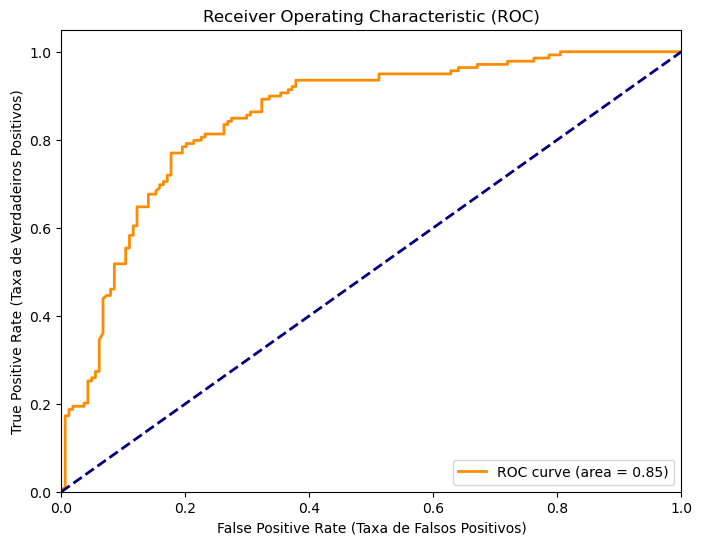

In [52]:

# Calculando a curva ROC e a área sob a curva (AUC)
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)

# Gráfico da curva ROC
plt.figure(figsize=(8, 6))
lw = 2  # Largura da linha

# Plotando a curva ROC
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc_)

# Linha de referência (curva aleatória)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

# Ajustando os limites e labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Taxa de Falsos Positivos)')
plt.ylabel('True Positive Rate (Taxa de Verdadeiros Positivos)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


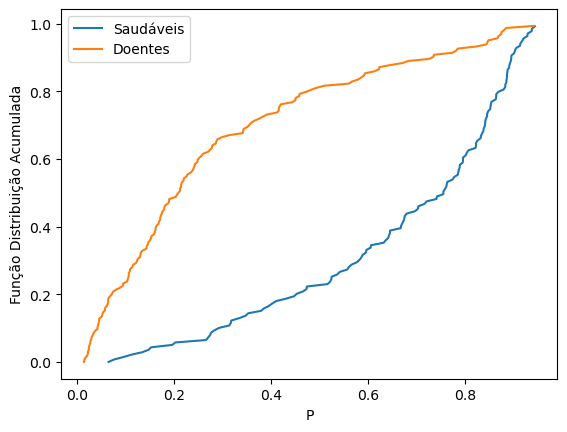

In [55]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

score_pop1 = df.loc[df['flag_doente'] == 1, 'predito']
ax.plot(np.sort(score_pop1), np.linspace(
    0, 1, len(score_pop1), endpoint=False), label='Saudáveis')

score_pop2 = df.loc[df['flag_doente'] != 1, 'predito']
ax.plot(np.sort(score_pop2), np.linspace(
    0, 1, len(score_pop2), endpoint=False), label='Doentes')
ax.legend()

ax.set_xlabel('P')
ax.set_ylabel('Função Distribuição Acumulada')
plt.show()

In [60]:
# Acurácia
acc = metrics.accuracy_score(df['flag_doente'], df['predito'] > .5)
print('Acurácia: {0:.2f}%'.format(acc*100))

# AUC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)

# GINI
gini = 2 * auc_ -1

# KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'predito'], df.loc[df['flag_doente'] != 1, 'predito']).statistic

# print(f'AUC: {auc_*100:.2f}%')
print(f'GINI: {gini*100:.2f}%')
print(f'KS: {ks*100:.2f}%')

Acurácia: 82.84%
GINI: 78.04%
KS: 66.27%


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

In [61]:
reglog = smf.logit(formula='''flag_doente 
                            ~ age
                            + sex 
                            + C(cp, Treatment(reference=4))
                            + thalach
                            + exang
                            + oldpeak
                            ''', 
                   data=df).fit()
reglog.summary()

Optimization terminated successfully.
         Current function value: 0.414266
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      294
Method:                           MLE   Df Model:                            8
Date:                Wed, 22 Jan 2025   Pseudo R-squ.:                  0.3994
Time:                        11:39:56   Log-Likelihood:                -125.52
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 5.652e-32
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -0.6474      2.025     -0.320      0.749      -4.617       3.322
C(cp, Treatment(reference=4))[T.1.0]    -2.1539      0.594     -3.625      0.000      -3.319      -0.989
C(cp, Treatment(reference=4))[T.2.0]    -1.4851      0.485     -3.065      0.002      -2.435      -0.535
C(cp, Treatment(reference=4))[T.3.0]    -1.9797      0.405     -4.893      0.000      -2.773      -1.187
age                                      0.0394      0.020      1.984      0.047       0.000       0.078
sex                                      1.6929      0.379      4.463      0.000       0.949       2.436
thalach                                 -0.0192      0.009     -2.207      0.027      -0.036      -0.002
exang                                    0.8612      0.366      2.354      0.019       0.144       1.578
oldpeak                                  0.6968      0.170      4.108      0.000       0.364       1.029
========================================================================================================
"""

In [63]:
df['predito'] = reglog.predict(exog=df)

# Categorizando essa probabilidade em 5 grupos:
pred_cat = pd.qcut(x=df['predito'], q=5)

# Adicionando observed=True ao groupby
group_reg = df.groupby(by=pred_cat, observed=True)

qualid = (group_reg[['flag_doente']].count().rename(columns={'flag_doente': 'contagem'}))

# Calculando a probabilidade de evento predita média por grupo:
qualid['predito'] = group_reg['predito'].mean()

# Calculando a taxa de eventos (média da variável indicadora de eventos) por grupo:
qualid['pct_doente'] = group_reg['flag_doente'].mean()

# Acurácia
acc = metrics.accuracy_score(df['flag_doente'], df['predito'] > 0.5)
print('Acurácia: {0:.2f}%'.format(acc * 100))

# AUC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)

# GINI
gini = 2 * auc_ - 1

# KS
ks = ks_2samp(
    df.loc[df['flag_doente'] == 1, 'predito'],
    df.loc[df['flag_doente'] != 1, 'predito']
).statistic

# Resultados
print(f'AUC: {auc_ * 100:.2f}%')
print(f'GINI: {gini * 100:.2f}%')
print(f'KS: {ks * 100:.2f}%')


Acurácia: 82.84%
AUC: 89.02%
GINI: 78.04%
KS: 66.27%
